Notebook to explore distance metric with simplified DEM

In [1]:
import os
import h5py
import numpy as np 
from scipy.stats import wasserstein_distance as EarthMover
# -- galpopfm
from galpopfm import dustfm as dustFM
from galpopfm import dust_infer as dustInfer
from galpopfm import measure_obs as measureObs
# -- plotting --
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
dat_dir = os.environ['GALPOPFM_DIR']

Read in SDSS observables

In [3]:
f_obs = os.path.join(dat_dir, 'obs', 'tinker_SDSS_centrals_M9.7.Mr_complete.Mr_GR_FUVNUV.npy') 
r_edges, gr_edges, fn_edges, _, _ = np.load(f_obs, allow_pickle=True)

In [4]:
x_obs_2d = dustInfer.sumstat_obs(name='sdss', statistic='2d')
x_obs_1d = dustInfer.sumstat_obs(name='sdss', statistic='1d')

In [5]:
dr = r_edges[1] - r_edges[0]
dgr = gr_edges[1] - gr_edges[0]
dfn = fn_edges[1] - fn_edges[0]
nbins = [len(r_edges)-1, len(gr_edges)-1, len(fn_edges)-1]
ranges = [(r_edges[0], r_edges[-1]), (gr_edges[0], gr_edges[-1]), (fn_edges[0], fn_edges[-1])]

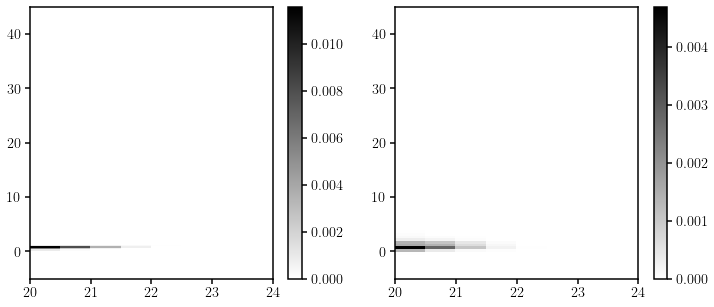

In [6]:
fig = plt.figure(figsize=(12,5))
sub = fig.add_subplot(121)
h = sub.pcolormesh(r_edges, gr_edges, x_obs_2d[1].T, cmap='gist_gray_r')
plt.colorbar(h, ax=sub)

sub = fig.add_subplot(122)
h = sub.pcolormesh(r_edges, fn_edges, x_obs_2d[2].T, cmap='gist_gray_r')
plt.colorbar(h, ax=sub)

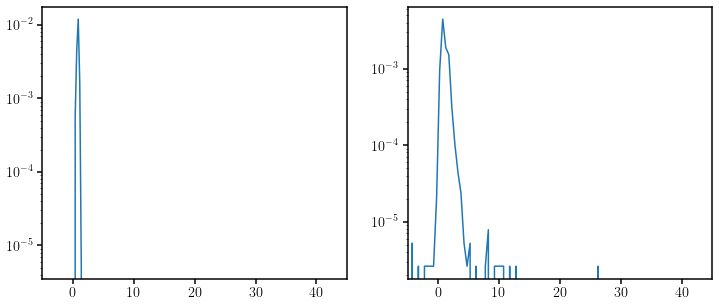

In [7]:
fig = plt.figure(figsize=(12,5))
sub = fig.add_subplot(121)
sub.plot(0.5 * (gr_edges[1:] + gr_edges[:-1]), x_obs_1d[1])
sub.set_xlim(ranges[1])
sub.set_yscale('log')

sub = fig.add_subplot(122)
sub.plot(0.5 * (fn_edges[1:] + fn_edges[:-1]), x_obs_1d[2])
sub.set_xlim(ranges[2])
sub.set_yscale('log')

Read in simulation data

In [8]:
sim_sed = dustInfer._read_sed('simba') 

# pass through the minimal amount of memory 
wlim = (sim_sed['wave'] > 1e3) & (sim_sed['wave'] < 8e3) 
# only keep centrals and impose mass limit as well.
# the lower limit log M* > 9.4 is padded by >0.25 dex to conservatively account
# for log M* and R magnitude scatter  
downsample = np.zeros(len(sim_sed['logmstar'])).astype(bool)
downsample[::10] = True
f_downsample = 0.1
cens = sim_sed['censat'].astype(bool) & (sim_sed['logmstar'] > 9.4) & downsample

# global variable that can be accessed by multiprocess (~2GB) 
sed = {} 
sed['sim']           = 'simba' 
sed['logmstar']      = sim_sed['logmstar'][cens].copy()
sed['logsfr.100']    = sim_sed['logsfr.100'][cens].copy() 
sed['wave']          = sim_sed['wave'][wlim].copy()
sed['sed_noneb']     = sim_sed['sed_noneb'][cens,:][:,wlim].copy() 
sed['sed_onlyneb']   = sim_sed['sed_onlyneb'][cens,:][:,wlim].copy() 

In [9]:
def model_observable_1d(theta, dem='slab_noll_simple'): 
    return dustInfer.sumstat_model(theta, sed=sed, dem=dem, 
                                   f_downsample=f_downsample, 
                                   statistic='1d')

In [10]:
def model_observable_2d(theta, dem='slab_noll_simple'): 
    return dustInfer.sumstat_model(theta, sed=sed, dem=dem, 
                                   f_downsample=f_downsample, 
                                   statistic='2d')

nbar_obs 0.004672646881110662
nbar_mod 0.00215
L2
     (6.36374728677735e-06, 8.69697489831123e-05, 2.6247310560620116e-05)
L1
     (0.0025226468811106618, 0.014141683010506525, 0.010740596839781378)
nbar_obs 0.004672646881110662
nbar_mod 0.0030299999999999997
L2
     (2.6982887760225857e-06, 0.00019379038481969794, 2.8826305101867366e-05)
L1
     (0.001642646881110662, 0.027430098193498873, 0.015400071468976161)
nbar_obs 0.004672646881110662
nbar_mod 0.00167
L2
     (9.015888292643585e-06, 0.00017201469101739162, 2.788664273191743e-05)
L1
     (0.0030026468811106617, 0.02208014293795232, 0.012627848536524518)


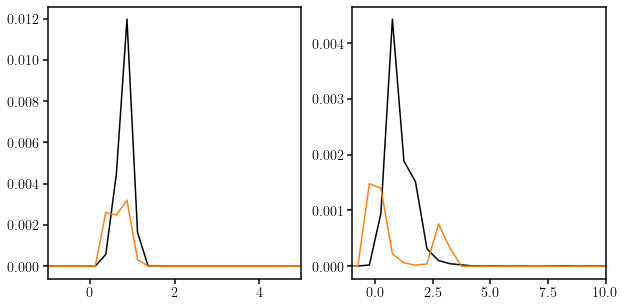

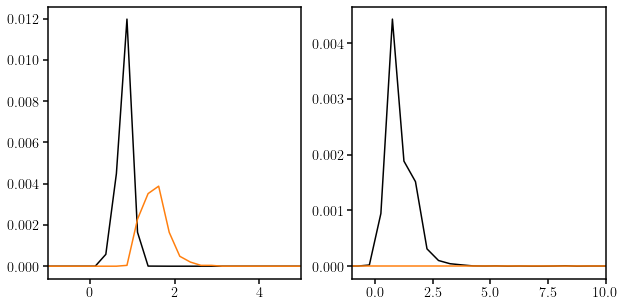

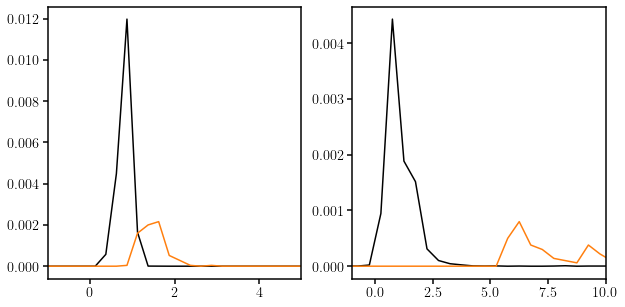

In [16]:
thetas = [np.array([3., 0.5]), np.array([3., -2]), np.array([5., -1.])]#, np.array([0., 0.]), np.array([5., 5.])]
for _theta in thetas: 
    x_model = model_observable_1d(_theta, dem='slab_noll_simple')
    print('nbar_obs', x_obs_1d[0])
    print('nbar_mod', x_model[0])
    print('L2')
    dustInfer.distance_metric(x_obs_1d, x_model, method='L2')
    print('L1')
    dustInfer.distance_metric(x_obs_1d, x_model, method='L1')
    
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(121)
    sub.plot(0.5 * (gr_edges[1:] + gr_edges[:-1]), x_obs_1d[1], c='k')
    sub.plot(0.5 * (gr_edges[1:] + gr_edges[:-1]), x_model[1], c='C1')
    sub.set_xlim(-1, 5)
    #sub.set_yscale('log')

    sub = fig.add_subplot(122)
    sub.plot(0.5 * (fn_edges[1:] + fn_edges[:-1]), x_obs_1d[2], c='k')
    sub.plot(0.5 * (fn_edges[1:] + fn_edges[:-1]), x_model[2], c='C1')
    sub.set_xlim(-1, 10)
    #sub.set_yscale('log')

nbar_obs 0.004672646881110662
nbar_mod 0.00207
L2
     (6.7737707877550565e-06, 9.06828053829443e-05, 2.6539322229518216e-05)
L1
     (0.002602646881110662, 0.014541683010506524, 0.010620596839781378)
nbar_obs 0.004672646881110662
nbar_mod 0.011039999999999996
L2
     (4.054318574062973e-05, 0.000663705058346958, 0.00019607947108280462)
L1
     (0.006367353118889334, 0.05184978321531445, 0.0245535962005749)
nbar_obs 0.004672646881110662
nbar_mod 0.00027000000000000006
L2
     (1.9383299559753434e-05, 0.0001670100470378503, 2.626699154393027e-05)
L1
     (0.0044026468811106615, 0.019770587524442645, 0.009279845979698607)


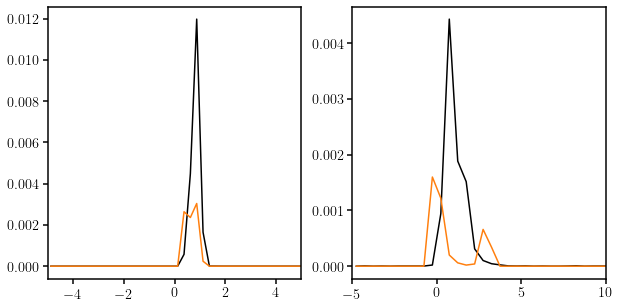

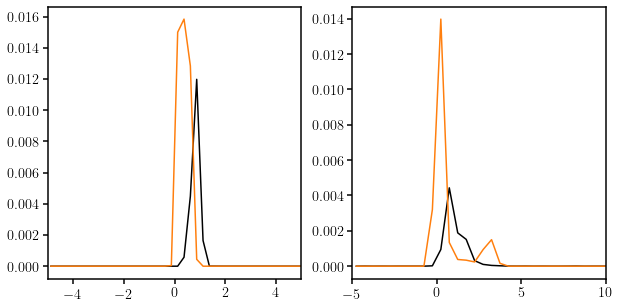

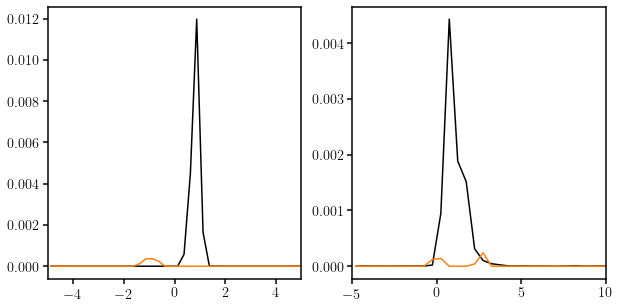

In [15]:
thetas = [np.array([3., 0.5]), np.array([0., 0.]), np.array([5., 5.])]
for _theta in thetas: 
    x_model = model_observable_1d(_theta, dem='slab_noll_simple')
    print('nbar_obs', x_obs_1d[0])
    print('nbar_mod', x_model[0])
    print('L2')
    dustInfer.distance_metric(x_obs_1d, x_model, method='L2')
    print('L1')
    dustInfer.distance_metric(x_obs_1d, x_model, method='L1')

    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(121)
    sub.plot(0.5 * (gr_edges[1:] + gr_edges[:-1]), x_obs_1d[1], c='k')
    sub.plot(0.5 * (gr_edges[1:] + gr_edges[:-1]), x_model[1], c='C1')
    sub.set_xlim(-5, 5)
    #sub.set_yscale('log')

    sub = fig.add_subplot(122)
    sub.plot(0.5 * (fn_edges[1:] + fn_edges[:-1]), x_obs_1d[2], c='k')
    sub.plot(0.5 * (fn_edges[1:] + fn_edges[:-1]), x_model[2], c='C1')
    sub.set_xlim(-5, 10)
    #sub.set_yscale('log')

nbar_obs (0.004672646881110662,)
nbar_mod 0.00199
L2
     (7.196594288732761e-06, 0.001157392315971219, 0.00020674779390762022)
L1
     (0.0026826468811106618, 0.1381579866537328, 0.07505130343569773)


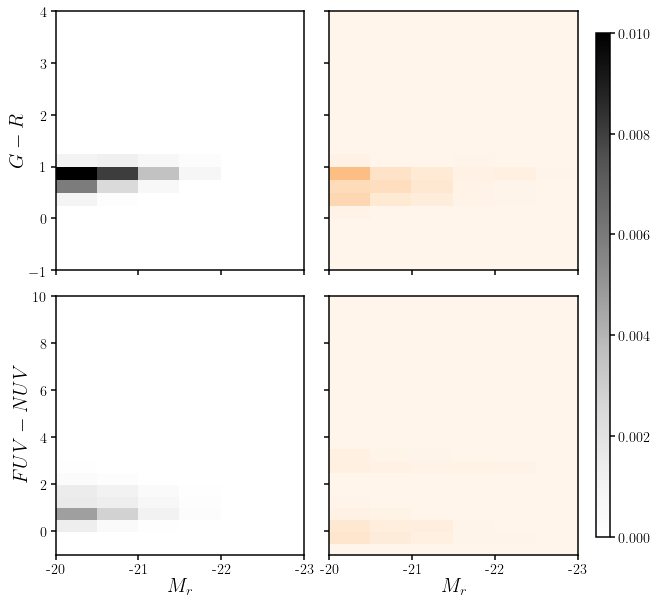

In [20]:
x_model = model_observable_2d(np.array([3., 0.5]), dem='slab_noll_simple')
print('nbar_obs', x_obs_2d[0])
print('nbar_mod', x_model[0])
print('L2')
dustInfer.distance_metric(x_obs_1d, x_model, method='L2')
print('L1')
dustInfer.distance_metric(x_obs_1d, x_model, method='L1')

fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(221)
sub.pcolormesh(r_edges, gr_edges, x_obs_2d[1].T, vmax=1e-2, cmap='Greys')
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([])
sub.set_ylabel(r'$G-R$', fontsize=20) 
sub.set_ylim(-1, 4)  

sub = fig.add_subplot(222)
sub.pcolormesh(r_edges, gr_edges, x_model[1].T, vmax=1e-2, cmap='Oranges')
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([])
sub.set_ylim(-1, 4)  
sub.set_yticklabels([])

sub = fig.add_subplot(223)
h = sub.pcolormesh(r_edges, fn_edges, x_obs_2d[2].T, vmax=1e-2, cmap='Greys')
sub.set_xlabel(r'$M_r$', fontsize=20) 
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([-20, -21, -22, -23]) 
sub.set_ylabel(r'$FUV - NUV$', fontsize=20) 
sub.set_ylim(-1, 10)  

sub = fig.add_subplot(224)
sub.pcolormesh(r_edges, fn_edges, x_model[2].T, vmax=1e-2, cmap='Oranges')
sub.set_xlabel(r'$M_r$', fontsize=20) 
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([-20, -21, -22, -23]) 
sub.set_ylim(-1, 10) 
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
fig.colorbar(h, cax=cbar_ax)

nbar_obs (0.004672646881110662,)
nbar_mod 0.0016899999999999999
L2
     (8.89618241739916e-06, 0.001340843610073778, 0.0002143402316675265)
L1
     (0.002982646881110662, 0.1558029218495799, 0.08137090359366084)


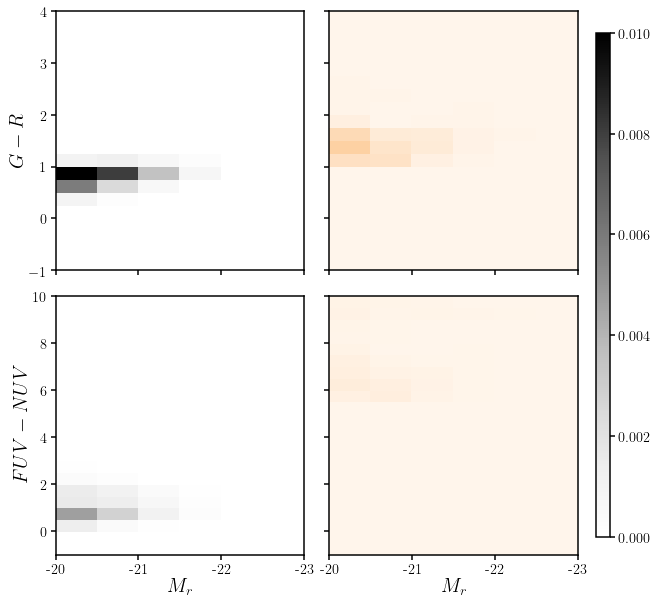

In [19]:
x_model = model_observable_2d(np.array([5., -1.]), dem='slab_noll_simple')
print('nbar_obs', x_obs_2d[0])
print('nbar_mod', x_model[0])
print('L2')
dustInfer.distance_metric(x_obs_1d, x_model, method='L2')
print('L1')
dustInfer.distance_metric(x_obs_1d, x_model, method='L1')

fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(221)
sub.pcolormesh(r_edges, gr_edges, x_obs_2d[1].T, vmax=1e-2, cmap='Greys')
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([])
sub.set_ylabel(r'$G-R$', fontsize=20) 
sub.set_ylim(-1, 4)  

sub = fig.add_subplot(222)
sub.pcolormesh(r_edges, gr_edges, x_model[1].T, vmax=1e-2, cmap='Oranges')
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([])
sub.set_ylim(-1, 4)  
sub.set_yticklabels([])

sub = fig.add_subplot(223)
h = sub.pcolormesh(r_edges, fn_edges, x_obs_2d[2].T, vmax=1e-2, cmap='Greys')
sub.set_xlabel(r'$M_r$', fontsize=20) 
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([-20, -21, -22, -23]) 
sub.set_ylabel(r'$FUV - NUV$', fontsize=20) 
sub.set_ylim(-1, 10)  

sub = fig.add_subplot(224)
sub.pcolormesh(r_edges, fn_edges, x_model[2].T, vmax=1e-2, cmap='Oranges')
sub.set_xlabel(r'$M_r$', fontsize=20) 
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([-20, -21, -22, -23]) 
sub.set_ylim(-1, 10) 
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
fig.colorbar(h, cax=cbar_ax)